<div>
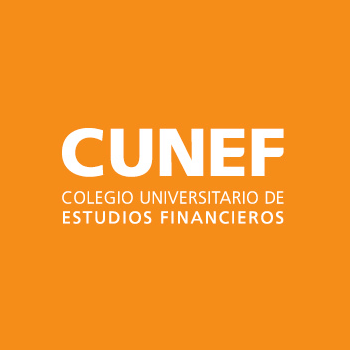
</div>

# **Matriculaciones en España**

En este notebook se mostrará la serie temporal de las **matriculaciones de vehículos en España** y observaremos cómo afectó ésta frente al COVID-19. 

Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura y preprocesado de los datos
    3) Análisis exploratorio
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
    5) Predicción hasta finales de año 

## *Librerías*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *Lectura del Excel y preparación de los datos*
Se procede a leer el archivo Excel de las matriculaciones de vehículos comerciales que han habido en España. 
Fuente: https://datosmacro.expansion.com/negocios/matriculaciones-vehiculos/espana



In [2]:
df_matriculaciones = pd.read_excel("matriculaciones.xlsx", index_col=0)
df_matriculaciones

,Vehículos comerciales Mes,Vehículos pasajeros Mes,Venta mensual vehículos,Vehículos Mes/1000 hab.,Vehículos comerciales Año,Vehículos pasajeros Año,Venta anual vehículos,Vehículos Año/1000 hab.
Fecha,,,,,,,,
2014-01-01,8613,53436,62052,1.33,102925,726461,829382,17.83
2014-02-01,9638,68763,78401,1.69,106102,736852,842950,18.12
2014-03-01,10558,79928,90485,1.95,108332,744102,852429,18.33
2014-04-01,12323,80174,92497,1.99,112686,761959,874640,18.80
2014-05-01,11649,82483,94132,2.02,116111,773896,890001,19.13
...,...,...,...,...,...,...,...,...
2022-03-01,11880,59920,71534,1.51,160445,837831,996106,21.05
2022-04-01,11077,69111,80188,1.69,153867,828348,980163,20.71
2022-05-01,12844,84977,97652,2.06,148756,817921,964361,20.66


Vamos a quedarnos de nuestro DataFrame las columnas de vehículos comerciales/mes, vehículos pasajeros/mes y la venta mensual de vehículos, que es la suma de comerciales y pasajeros. Entendemos por coches comerciales aquellos que son diseñados para empresas y autónomos, furgonetas y camiones destinados al trabajo, al transporte de mercancías e incluso desempeñan funciones especiales como vehículos policiales, de emergencias o ambulancias. 

In [3]:
df_matriculaciones = df_matriculaciones.iloc[:,0:3]
df_matriculaciones

,Vehículos comerciales Mes,Vehículos pasajeros Mes,Venta mensual vehículos
Fecha,,,
2014-01-01,8613,53436,62052
2014-02-01,9638,68763,78401
2014-03-01,10558,79928,90485
2014-04-01,12323,80174,92497
2014-05-01,11649,82483,94132
...,...,...,...
2022-03-01,11880,59920,71534
2022-04-01,11077,69111,80188
2022-05-01,12844,84977,97652


## *Graficación de la serie temporal*



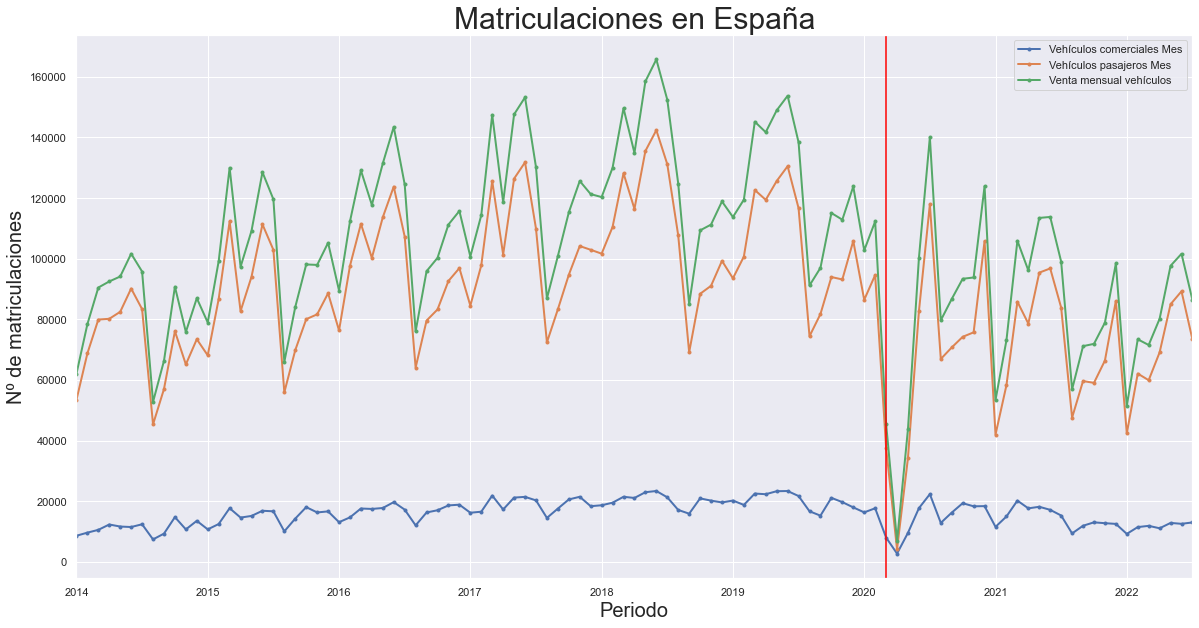

In [4]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_matriculaciones.plot(marker='.', linewidth= 2)
fig.set_title('Matriculaciones en España', fontsize = 30)
fig.set_ylabel('Nº de matriculaciones', fontsize = 20)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 20);

Apreciamos en la gráfica que la venta mensual de vehículos es bastante similar a la serie temporal de matriculaciones de vehículos pasajeros, y sigue una tendencia creciente con altibajos marcados en los mismos meses hasta llegar a marzo del 2020, momento en el que comienzan las restricciones por COVID-19. Lo que resulta llamativo es que realiza una caída importante en el mes de abril del 2020, y acto seguido se recuperan las matriculaciones prácticamente al mismo nivel que hubo en los últimos meses del año 2019, aunque parece que está llevando una tendencia decreciente y aplanándose poco a poco.

En cuanto a las matriculaciones de vehículos comerciales podemos apreciar que hay una tímida tendencia creciente hasta llegar al período COVID, donde hay una caída pero luego se vuelve a recuperar de la misma manera que con las matriculaciones de vehículos de pasajeros. 

Habiéndonos puesto ya en contexto, vamos a quedarnos solamente con la columna de **venta mensual de vehículos** para un análisis más exhaustivo.

In [5]:
df_matriculaciones = df_matriculaciones.iloc[:,-1:]
df_matriculaciones

,Venta mensual vehículos
Fecha,
2014-01-01,62052
2014-02-01,78401
2014-03-01,90485
2014-04-01,92497
2014-05-01,94132
...,...
2022-03-01,71534
2022-04-01,80188
2022-05-01,97652


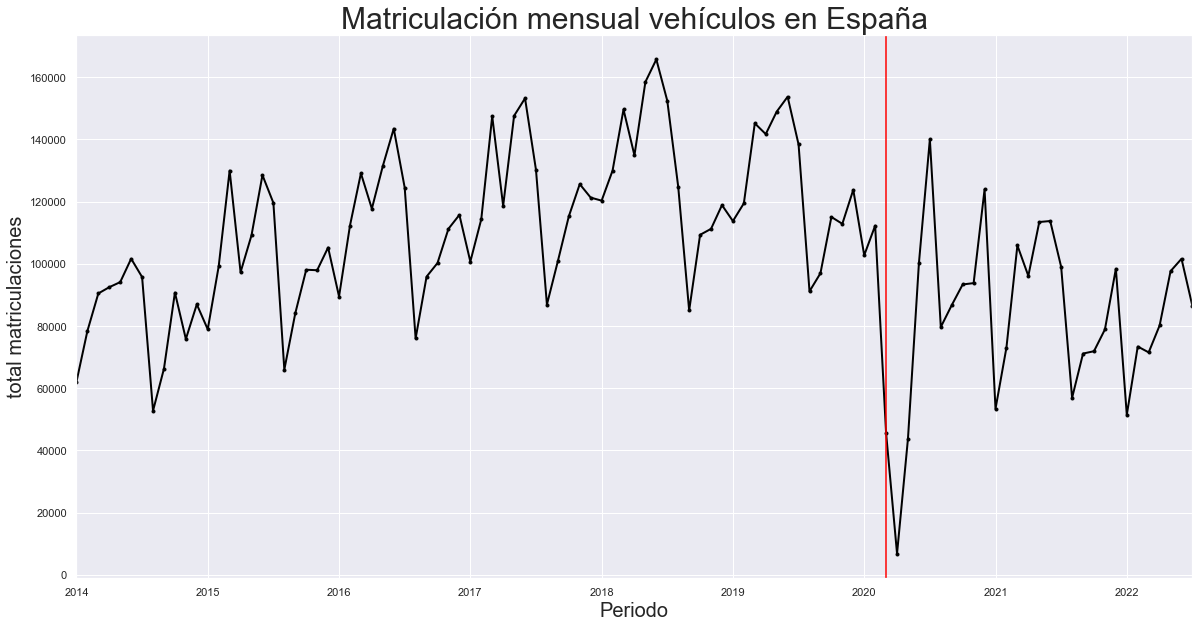

In [6]:
# Ploteamos de nuevo nuestra serie temporal:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_matriculaciones['Venta mensual vehículos'].plot(marker='.', color = 'black', linewidth= 2)
fig.set_title('Matriculación mensual vehículos en España', fontsize = 30)
fig.set_ylabel('total matriculaciones', fontsize = 20)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 20);

A continuación, analizaremos la estacionalidad mediante:
- Cálculo de la media y de la varianza
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y residuos

In [7]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [8]:
media = split_and_summarize(df_matriculaciones, 'Venta mensual vehículos', 4, np.mean)

varianza = split_and_summarize(df_matriculaciones, 'Venta mensual vehículos', 4, np.var)

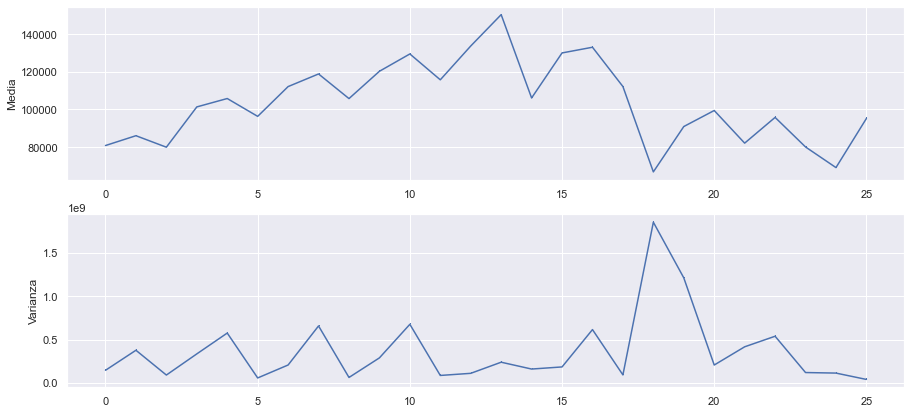

In [9]:
cols = ['media', 'varianza']
df = pd.DataFrame([media, varianza], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')

plt.show()

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

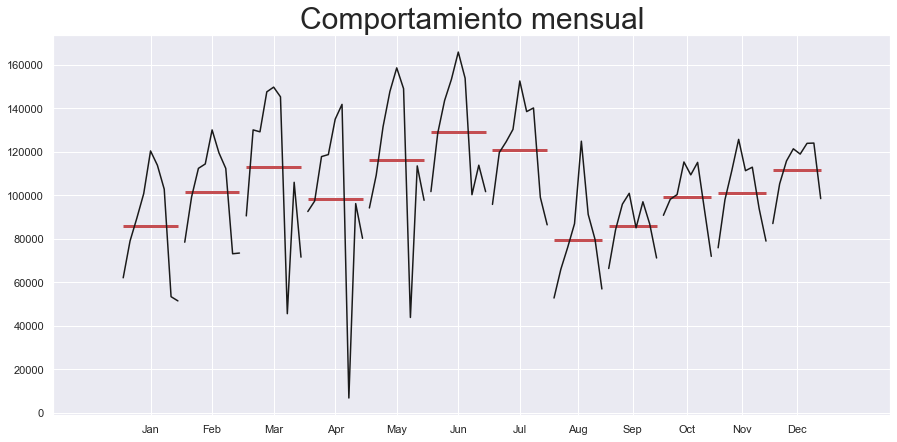

In [10]:
# Componente estacional mensual:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_matriculaciones['Venta mensual vehículos'], ax = ax)
ax.set_title('Comportamiento mensual', fontsize = 30);

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

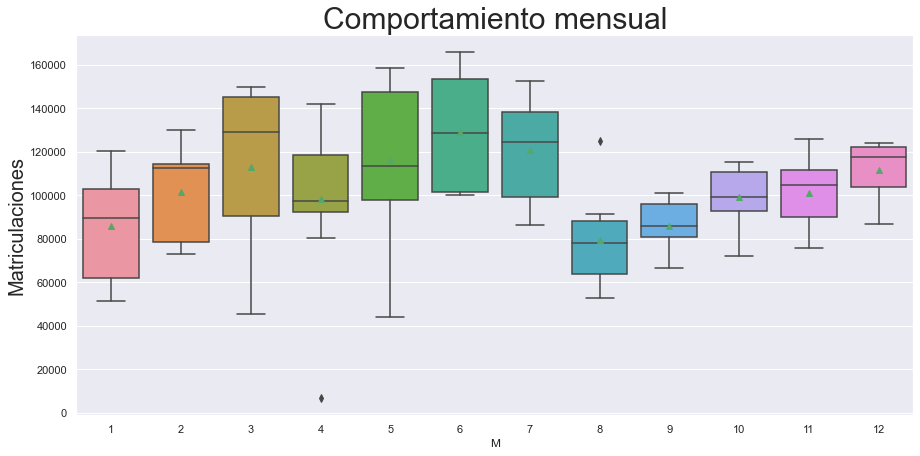

In [11]:
df_matriculaciones['M'] = df_matriculaciones.index.month
sns.boxplot(data = df_matriculaciones, x = 'M', y='Venta mensual vehículos', showmeans=True)
ax = plt.gca()
ax.set_ylabel('Matriculaciones', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);

Y, por último, el desglose de la estacionalidad, tendencia y residuos:

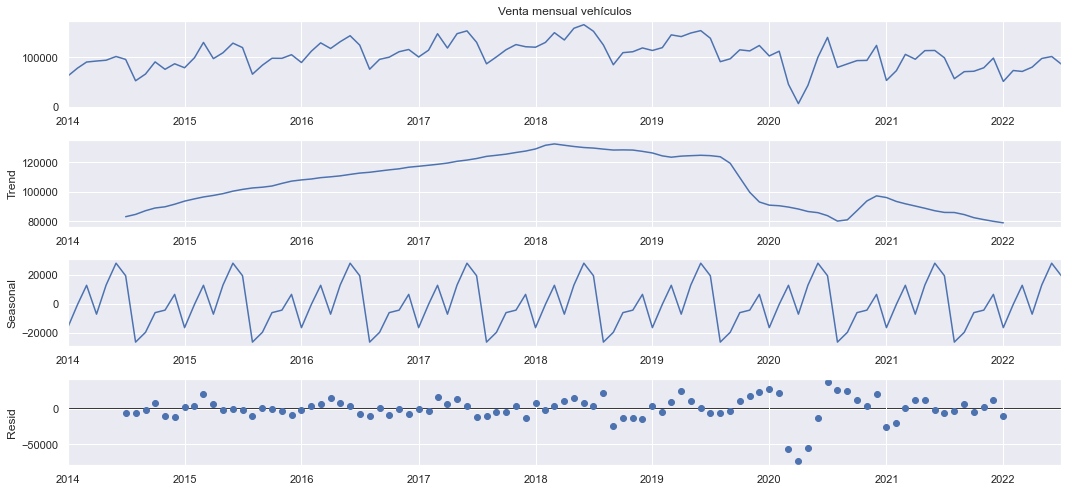

In [12]:
desglose = seasonal_decompose(df_matriculaciones['Venta mensual vehículos'], 
                                   model='additive', 
                                   period=12);
desglose.plot();

Analizando las gráficas, observamos:

- Que **puede existir una ligera tendencia creciente** de nuevas matriculaciones hasta el momento COVID, que como ya hemos dicho anteriormente, se genera un pico de caída pero que luego se recupera, aunque desde 2021 lleva una tendencia decreciente.
- Que **no es una serie estacionaria**, ya que ni su media ni su varianza son constantes a lo largo del periodo. 
- Que **existe una fuerte estacionalidad** (hasta el momento COVID): los meses donde más se venden nuevos vehículos son los de mayo y junio, a principios de verano. También se puede apreciar que hay menos matriculaciones en los meses de abril, que coincide normalmente con la época de Semana Santa, y en el mes de agosto.

## *4) Estimación mediante modelos*



### 4.1) Modelo de Suavizado Exponencial (ETS)

Cantidad de períodos en Train: 74
Cantidad de períodos en Test: 29


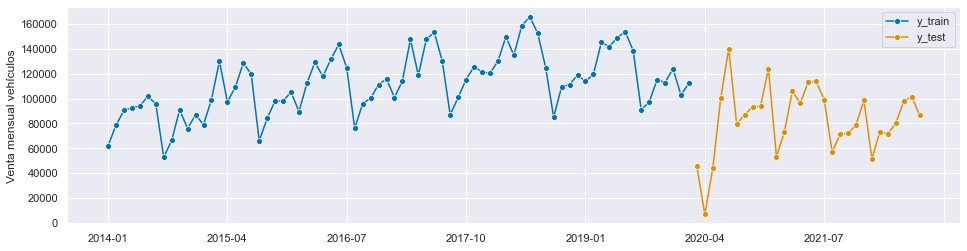

In [13]:
#Train-test
y_train,y_test=temporal_train_test_split(
    y=df_matriculaciones['Venta mensual vehículos'].astype('float64').to_period('M').sort_index(),
    test_size=29)
# Grafico para representar la separación de los datos
plot_series(y_train, y_test, labels=["y_train","y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test.shape[0])
plt.show()

In [14]:
y_test

2020-03     45566.0
2020-04      6833.0
2020-05     43831.0
2020-06    100217.0
2020-07    140071.0
2020-08     79676.0
2020-09     86719.0
2020-10     93374.0
2020-11     93805.0
2020-12    123941.0
2021-01     53377.0
2021-02     73099.0
2021-03    105919.0
2021-04     96131.0
2021-05    113454.0
2021-06    113774.0
2021-07     99034.0
2021-08     56923.0
2021-09     71153.0
2021-10     71909.0
2021-11     78909.0
2021-12     98425.0
2022-01     51443.0
2022-02     73417.0
2022-03     71534.0
2022-04     80188.0
2022-05     97652.0
2022-06    101624.0
2022-07     86383.0
Freq: M, Name: Venta mensual vehículos, dtype: float64

In [15]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
matriculaciones_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)
matriculaciones_auto_ets.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [16]:
#step 5: querying predictions
matriculaciones_pred=matriculaciones_auto_ets.predict(fh=list(fh))
matriculaciones_pred.tail()

2022-03    142316.903700
2022-04    125427.243587
2022-05    138953.892683
2022-06    148383.541321
2022-07    132874.510681
Freq: M, dtype: float64

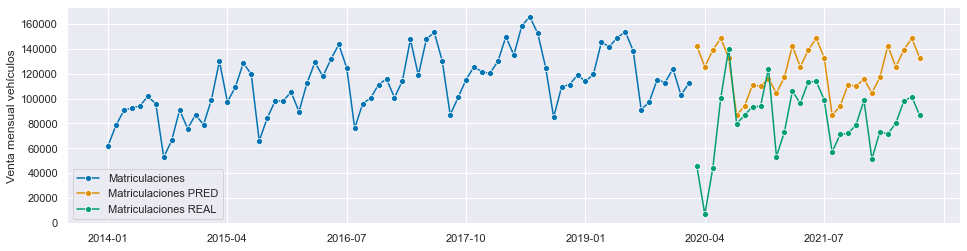

In [17]:
# optional: plotting predictions and past data
plot_series(y_train,matriculaciones_pred,y_test,
            labels=["Matriculaciones", "Matriculaciones PRED", "Matriculaciones REAL"])
plt.show()

In [18]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test, matriculaciones_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

El modelo ETS genera un RMSE de: 48176.82


In [19]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_ets = mape(y_test, matriculaciones_pred)
mape_ets
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un MAPE de: 111.76%


El modelo tiene un error muy grande, probablente haya que intervenir para que el error salga con un resultado más bajo y más lógico. No obstante, vamos a continuar con los modelos.

### 4.2) Modelo ARIMA

Al tratarse de una serie no estacionaria, transformamos la serie para tener un correcto tratamiento de la misma y de esta manera, obtener las mejores predicciones posibles con el método de estimacion ARIMA.

Es necesario lograr que la serie sea estacionaria en varianza, luego el algoritmo es capaz de interpretar datos no estacionarios en media. Para ello, **aplicaremos logaritmo** y luego lo ploteamos para evidenciar si se ha logrado el objetivo.

In [20]:
transformer = LogTransformer()
log_df_matriculaciones= transformer.fit_transform(df_matriculaciones)
log_df_matriculaciones.tail()

,Venta mensual vehículos,M
Fecha,,
2022-03-01,11.177928,1.098612
2022-04-01,11.292129,1.386294
2022-05-01,11.489165,1.609438
2022-06-01,11.529035,1.791759
2022-07-01,11.366546,1.945910


In [21]:
log_df_matriculaciones=log_df_matriculaciones.drop(['M'],axis=1)
log_df_matriculaciones

,Venta mensual vehículos
Fecha,
2014-01-01,11.035728
2014-02-01,11.269592
2014-03-01,11.412939
2014-04-01,11.434931
2014-05-01,11.452453
...,...
2022-03-01,11.177928
2022-04-01,11.292129
2022-05-01,11.489165


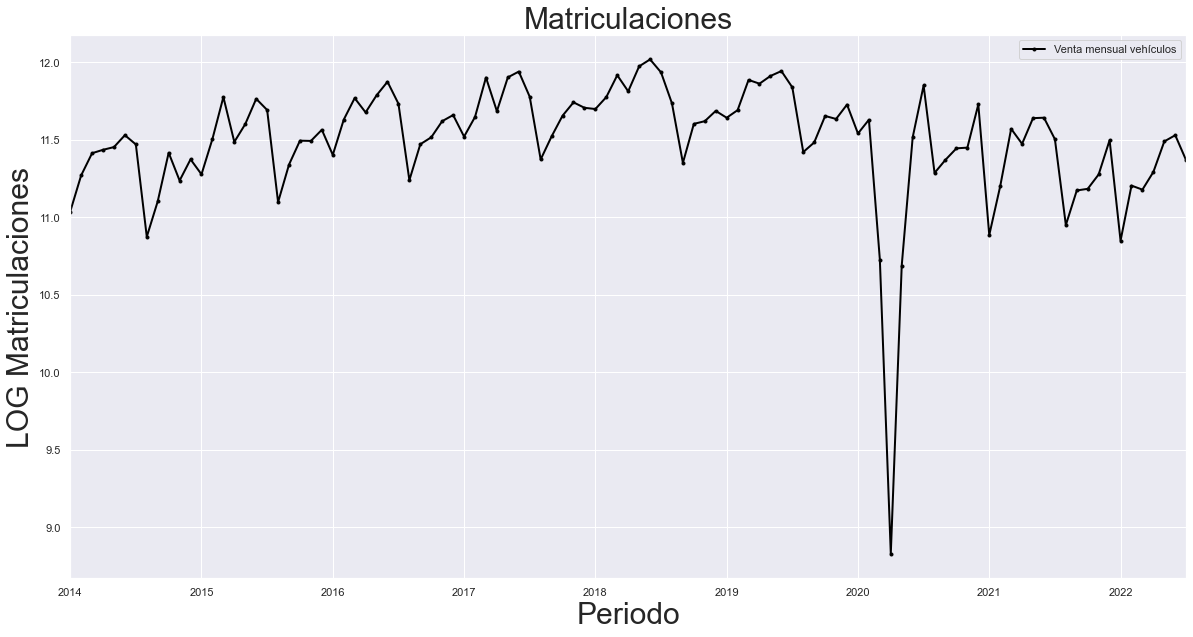

In [22]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = log_df_matriculaciones.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('Matriculaciones', fontsize = 30) 
fig.set_ylabel('LOG Matriculaciones', fontsize = 30)
fig.set_xlabel('Periodo', fontsize = 30);

Separamos el train y el test a la serie transformada con logs:

74 29


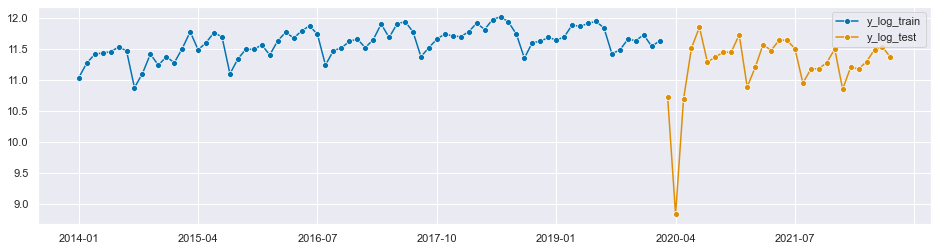

In [23]:
y_log_train,y_log_test=temporal_train_test_split(
    y=log_df_matriculaciones.astype('float64').to_period('M').sort_index(),test_size=29)

plot_series(y_log_train, y_log_test, labels=["y_log_train", "y_log_test"])
print(y_log_train.shape[0], y_log_test.shape[0])
plt.show()

Generamos el modelo y se entrena con los datos del train:

In [24]:
fh = np.arange(1, y_log_test.shape[0]+1)
matriculaciones_auto_arima=AutoARIMA(sp=12,suppress_warnings=True)

In [25]:
matriculaciones_auto_arima.fit(y_log_train)
matriculaciones_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   74
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                  60.133
Date:                            Tue, 23 Aug 2022   AIC                           -112.267
Time:                                    17:05:22   BIC                           -103.105
Sample:                                         0   HQIC                          -108.615
                                             - 74                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7492      0.074    -10.106      0.000      -0.894      -0.604
ar.S.L12       0.9634      0.018     54.590      0.000       0.929       0.998
ma.S.L12      -0.4398      0.125     -3.522      0.000      -0.685      -0.195
sigma2         0.0084      0.001      7.345      0.000       0.006       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                27.34
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.66
Prob(H) (two-sided):                  0.35   Kurtosis:                         5.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
matriculaciones_log_pred = matriculaciones_auto_arima.predict(fh)
print(np.exp(matriculaciones_log_pred))

         Venta mensual vehículos
2020-03            140474.394042
2020-04            131154.192367
2020-05            143927.197624
2020-06            149660.134564
2020-07            135493.883539
2020-08             95689.106138
2020-09             93546.915930
2020-10            110903.478449
2020-11            111471.897557
2020-12            118980.284862
2021-01            105551.570414
2021-02            114239.578560
2021-03            138669.094940
2021-04            129794.765385
2021-05            141951.166391
2021-06            147394.288910
2021-07            133929.627687
2021-08             95797.579393
2021-09             93730.690304
2021-10            110430.509524
2021-11            110975.714093
2021-12            118168.094466
2022-01            105292.078488
2022-02            113628.915892
2022-03            136951.890506
2022-04            128498.478078
2022-05            140073.202357
2022-06            145243.917131
2022-07            132439.770645


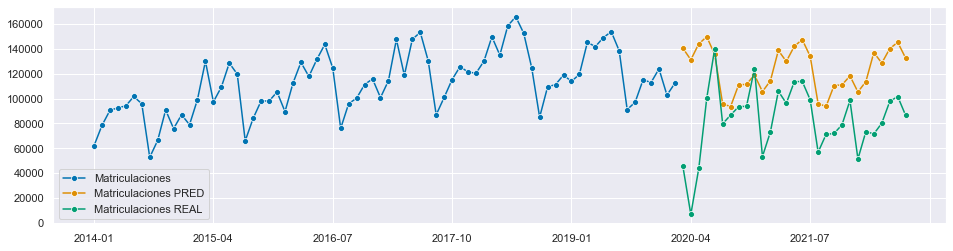

In [27]:
# representamos la serie predictiva
plot_series(np.exp(y_log_train), np.exp(matriculaciones_log_pred), np.exp(y_log_test),
            labels=["Matriculaciones", "Matriculaciones PRED", "Matriculaciones REAL"])
plt.show()

In [28]:
mse = MeanSquaredError(square_root=True)
mse_log = mse(np.exp(y_log_test), np.exp(matriculaciones_log_pred))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ARIMA genera un RMSE de: 48973.06


In [29]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_log = mape(np.exp(y_log_test), np.exp(matriculaciones_log_pred))
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_log*100,2)))

El modelo ARIMA genera un MAPE de: 115.63%


### Comparativa gráfica entre los modelos ETS y ARIMA

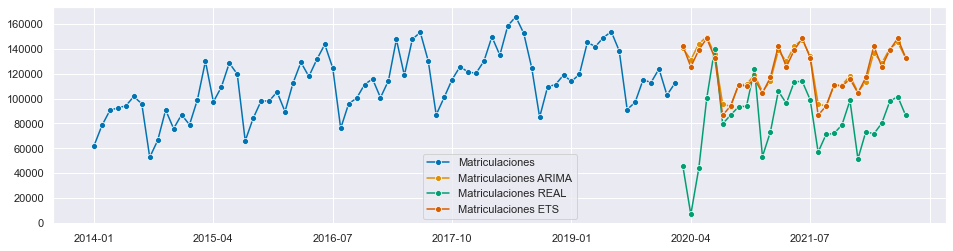

In [30]:
plot_series(np.exp(y_log_train["2013":]),np.exp(matriculaciones_log_pred),np.exp(y_log_test),
            matriculaciones_pred,labels=['Matriculaciones','Matriculaciones ARIMA',
                                         'Matriculaciones REAL','Matriculaciones ETS'])
plt.show()

Los modelos aquí son muy parejos prediciendo pero falla bastante. Probaremos con Prophet y si también da mucho fallo, intervenimos. 

### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 

Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [31]:
df_matriculaciones=df_matriculaciones.drop(['M'],axis=1)

In [32]:
prophet_train = df_matriculaciones.reset_index() #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

In [33]:
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

74

In [34]:
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

29

In [35]:
prophet_y_train.tail()

,ds,y
69,2019-10-31,115075.0
70,2019-11-30,112865.0
71,2019-12-31,123821.0
72,2020-01-31,102762.0
73,2020-02-29,112294.0


In [36]:
prophet_y_test.head()

,ds,y
0,2020-03-31,45566.0
1,2020-04-30,6833.0
2,2020-05-31,43831.0
3,2020-06-30,100217.0
4,2020-07-31,140071.0


In [37]:
m = Prophet()
m.fit(prophet_y_train)

17:05:23 - cmdstanpy - INFO - Chain [1] start processing
17:05:25 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

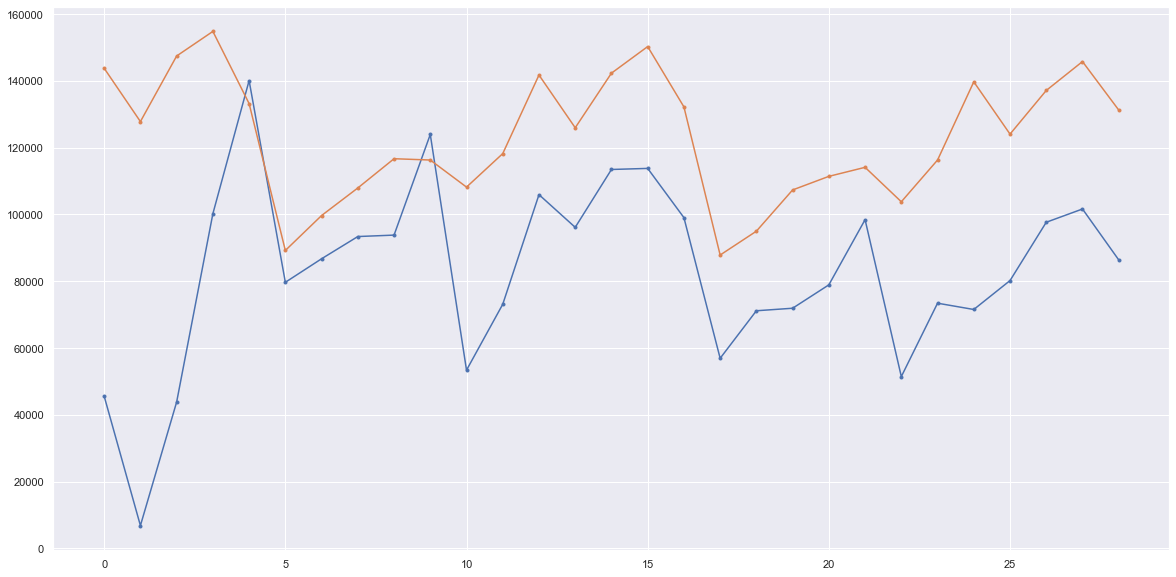

In [46]:
plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[74:, 'yhat']), '.-', label='Prediction')
plt.show()

In [45]:
# Forecast Accuracy
# MAPE
# mape_prophet = mean_absolute_percentage_error(prophet_y_test['y'], prophet_forecast.loc[47:, 'yhat'])
# mape_prophet

mape = MeanAbsolutePercentageError(symmetric=False)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[74:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

El modelo Prophet genera un MAPE de: 114.3%


In [47]:
# Forecast Accuracy
#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[74:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un RMSE de: 49234.02


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [49]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 48176.82
El modelo ARIMA genera un RMSE de: 48973.06
El modelo Prophet genera un RMSE de: 49234.02


2) MAPE (Error porcentual)

In [50]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet*100,2)))

El modelo ETS genera un MAPE de: 111.76%
El modelo ARIMA genera un MAPE de 115.63%
El modelo Prophet genera un MAPE de 114.3%


Aquí **el mejor modelo para la predicción de esta serie temporal es la ETS**, ya que es el que menor error da, aunque da errores muy altos.

## *5) Predicción hasta finales de año*

A continuación realizamos la predicción de la serie temporal del desempleo intervenido hasta finales de año, es decir, hasta diciembre del 2022. 

In [51]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, 6)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
autoets_predict = AutoETS(auto=True, sp=12, n_jobs=-1)
y = df_matriculaciones.astype('float64').to_period('M')
autoets_predict.fit(y)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [52]:
print(autoets_predict.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  103
Model:                       ETS(MNM)   Log Likelihood               -1155.083
Date:                Tue, 23 Aug 2022   AIC                           2342.166
Time:                        17:08:40   BIC                           2384.321
Sample:                    01-31-2014   HQIC                          2359.240
                         - 07-31-2022   Scale                            0.031
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.1622      0.026      6.280      0.000       0.112       0.213
smoothing_seasonal   8.378e-05        nan        nan        nan         nan         nan
initial_level   

In [53]:
# Predicción del desempleo para los próximos 6 meses:
matriculaciones_pred = autoets_predict.predict(fh=list(fh))
matriculaciones_pred.round()

,Venta mensual vehículos
2022-08,58813.0
2022-09,64028.0
2022-10,73290.0
2022-11,73714.0
2022-12,82743.0


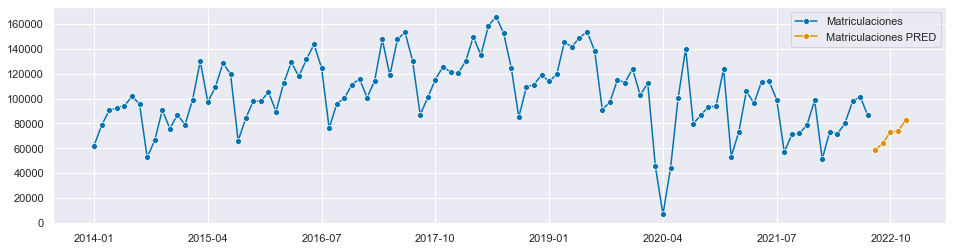

In [55]:
# Representamos gráficamente:
plot_series(y, matriculaciones_pred, labels=["Matriculaciones", "Matriculaciones PRED"])
plt.show()